<h1 align="center"> Credit Fraud Detector </h1>

데이터 : https://www.kaggle.com/mlg-ulb/creditcardfraud

Card fraud detection 데이터입니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib.patches as mpatches
import time

In [3]:
pd.options.display.max_columns=None

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import collections

/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

# 1. 데이터 로딩

In [6]:
df = pd.read_csv('./inputs/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Amount : Transaction amount
- Class : 1 for fraudulent transactions, 0 otherwise
- Time : Number of seconds elapsed between this transaction and the first transaction in the dataset
- V1 ~ V28 : may be result of a PCA Dimensionality reduction to protect user identities and sensitive features

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,8.176030e-16,1.206296e-15,4.913003e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


결측값을 확인합니다.

In [8]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

결측값은 존재하지 않습니다.

In [9]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Fraud vs Normal 데이터의 비율을 살펴보겠습니다.

In [10]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [11]:
# Normal data
print(df['Class'].value_counts()[0]/len(df) * 100)
# Fraud data
print(df['Class'].value_counts()[1]/len(df) * 100)

99.82725143693798
0.1727485630620034


**Imbalanced data**입니다. 

데이터에 대하여 normal이라고만 예측하는 모델을 만들면, 학습데이터의 경우 99.8%의 정확도를 가지게 됩니다. 

Fraud에 대한 패턴을 찾아내어야 하는데 쉽지 않은 문제입니다.

Text(0.5,1,'Class Distributions')

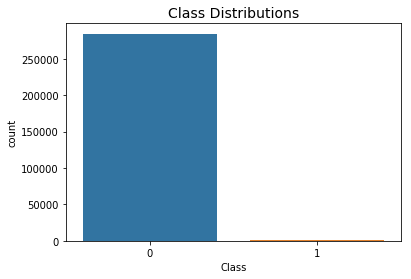

In [12]:
sns.countplot('Class', data=df)
plt.title('Class Distributions', fontsize=14)

- Transaction amount
- Transaction time

/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(0.0, 172792.0)

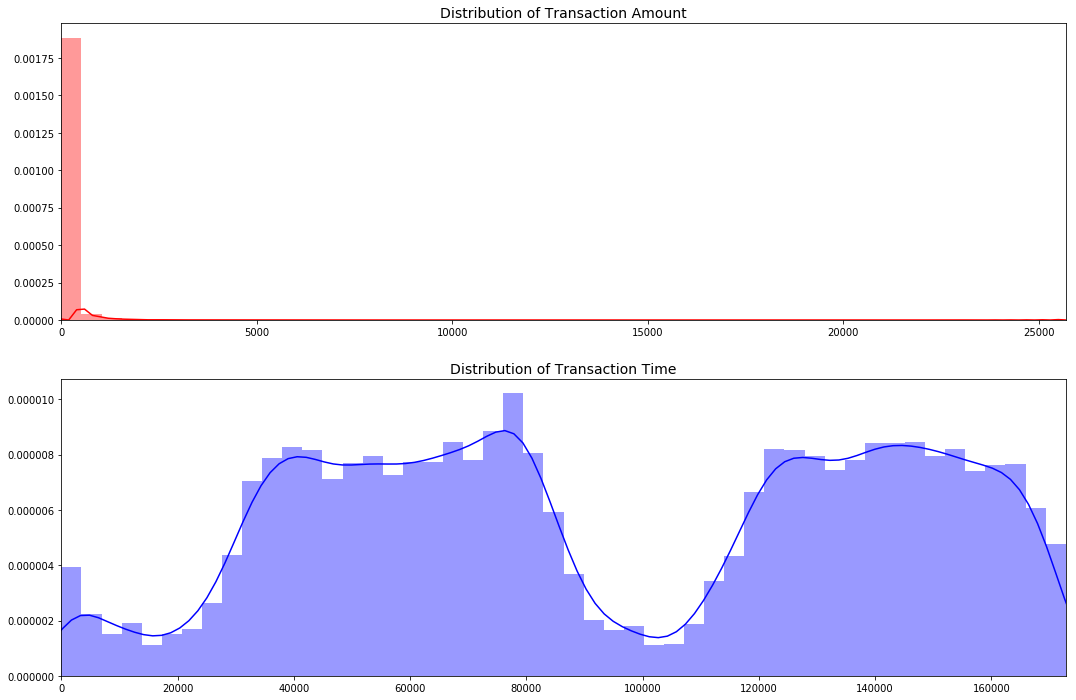

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(18,12))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

# 2. 데이터 전처리

## 2.1 Scailing
- StandardScaler : 평균과 표준편차 사용
- MinMaxScaler : 최대/최소값이 각각 1, 0이 되도록 스케일링
- MaxAbsScaler : 최대절대값과 0이 각각 1, 0이 되도록 스케일링
- [**RobustScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) : 중앙값(median)과 IQR(interquartile range) 사용. 아웃라이어의 영향을 최소화

In [14]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

# Imbalanced data : train/test set을 구분하고 train에서 학습 후, test에 적용해야 하지만, imbalanced인 관계로 우선 전체 대상으로 학습
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [15]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [16]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 2.2 Splitting the Data

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('Normal', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Normal 99.83 % of the dataset
Frauds 0.17 % of the dataset


**Stratified** train, test을 생성합니다.

참고 : https://en.wikipedia.org/wiki/Stratified_sampling#/media/File:Stratified_sampling.PNG

In [18]:
X = df.drop('Class', axis=1)
y = df['Class']

Stratified data를 완벽하게 보장받기 위하여, class 비율에 따라서 train set과 validation set을 나누어주는 `StratifiedKFold`를 사용하겠습니다. (Sklearn에서 제공해주는 train_test_split을 사용하지 않겠습니다.)

In [19]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print('===========')
    print("Train:", train_index, "Test:", test_index)
    original_X_train, original_X_test = X.iloc[train_index], X.iloc[test_index]
    original_y_train, original_y_test = y.iloc[train_index], y.iloc[test_index]
    print('train', Counter(original_y_train))
    print('test', Counter(original_y_test))

# CV 중 마지막 fold를 선택합니다.
original_X_train = original_X_train.values
original_X_test = original_X_test.values
original_y_train = original_y_train.values
original_y_test = original_y_test.values

# Unique label에 대한 count
train_unique_label, train_counts_label = np.unique(original_y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_y_test, return_counts=True)

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
train Counter({0: 227452, 1: 393})
test Counter({0: 56863, 1: 99})
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
train Counter({0: 227452, 1: 393})
test Counter({0: 56863, 1: 99})
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
train Counter({0: 227452, 1: 394})
test Counter({0: 56863, 1: 98})
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
train Counter({0: 227452, 1: 394})
test Counter({0: 56863, 1: 98})
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
train Counter({0: 227452, 1: 394})
test Counter({0: 56863, 1: 98})


In [20]:
print(train_counts_label / len(original_y_train))
print(test_counts_label / len(original_y_test))

[0.99827076 0.00172924]
[0.99827952 0.00172048]


## 2.3 <font color='red'>Random Under-Sampling</font>
<img src="http://glemaitre.github.io/imbalanced-learn/_images/sphx_glr_plot_random_under_sampler_001.png">

**Random Under Sampling** : Imbalanced data에서, data의 균형을 맞추기 위하여, 데이터를 **랜덤하게 제거**하는 과정입니다. 이 과정을 통해서, overfitting을 피할 수 있습니다.

- Imbalanced label의 비율 및 카운트를 구합니다.
- 훨씬 적은 라벨의 수에 맞추어(Fraud), major label에서 label를 추출하여(Non fraud, normal) 1:1의 비율을 맞춥니다.
- 추출된 데이터를 merge하고, 데이터를 shuffle 합니다.

이 과정에서 *당연히* 정보의 손실(information loss)가 발생합니다. 우리의 문제에서는 492개의 non-fraud transaction을 284,315개의 non-fraud transaction에서 뽑는 것이기 때문에 많은 양의 정보 손실이 발생할 수 있습니다.

In [21]:
# 데이터를 shuffle 한다.
df = df.sample(frac=1)

# 데이터 비율에 맞게 추출한다.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

# 데이터를 merge 한다.
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# 데이터를 shuffle 한다.
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
127888,-0.171872,-0.072639,1.460847,-1.074161,0.806203,-1.373100,-1.602463,-0.321650,-1.296488,-0.033152,-1.684100,1.367716,-0.198279,-0.523943,1.127650,-0.581928,1.030338,-0.468772,0.619806,-0.211164,-0.802999,-0.320319,-0.028066,0.402251,0.024936,0.093987,0.287697,-0.075641,0.072501,0.024716,0
64411,1.089779,-0.394236,-10.527304,7.639745,-13.443115,4.303403,-8.048210,-3.466997,-8.643193,7.284105,-2.362097,-5.996596,2.589104,-5.962261,-0.468955,-6.778184,0.907947,-3.970130,-6.857613,-2.511736,0.511762,0.847085,0.937416,-0.931178,-0.235697,-0.031393,0.591558,-0.263516,1.108897,0.219021,1
78342,0.243834,-0.319670,0.133631,0.536547,1.116747,1.464957,0.026074,-0.330254,0.464883,-0.198005,0.507389,-0.542993,-0.635510,0.322065,0.420942,-1.831082,-0.508533,-0.484960,0.920510,0.367846,0.517373,0.147626,0.058681,0.651525,0.088175,0.335017,-0.933050,-0.443964,0.101112,-0.008271,0
92777,3.813317,-0.242002,-6.133987,2.941499,-5.593986,3.258845,-5.315512,-0.637328,-4.476488,1.695994,-1.606743,-5.117259,3.977222,-8.066096,-0.760888,-8.660771,2.220238,-6.237597,-11.046382,-4.155879,1.763611,-0.815086,0.868340,0.793736,0.217347,-0.021985,0.145882,0.665088,-1.684186,0.310195,1
156988,-0.307413,0.289066,0.745153,2.809299,-5.825406,5.835566,0.512320,-0.615622,-2.916576,0.776710,-1.878832,-4.546936,4.698795,-8.507786,0.718249,-7.628710,-2.249578,-2.558669,-5.304624,-0.956938,-0.585322,0.402837,0.284841,-0.874383,-0.083995,-0.651442,0.454594,0.050376,0.756953,0.383869,1


In [22]:
print('Subsample에서의 데이터 비율')
new_df['Class'].value_counts() / len(new_df)

Subsample에서의 데이터 비율


1    0.5
0    0.5
Name: Class, dtype: float64

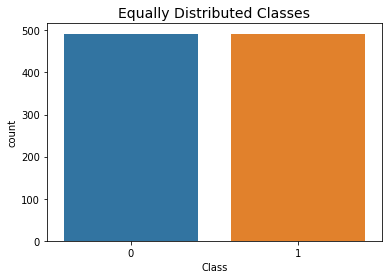

In [23]:
sns.countplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

# 3. EDA

## 3.1 Correlation 분석

> Imbalanced data (원래 데이터에서의 상관관계분석)

대부분의 라벨이 0이기 때문에 대부분의 상관관계가 0에 가깝게 나옵니다.

Text(0.5,1,"Imbalanced Correlation Matrix \n (don't use for reference)")

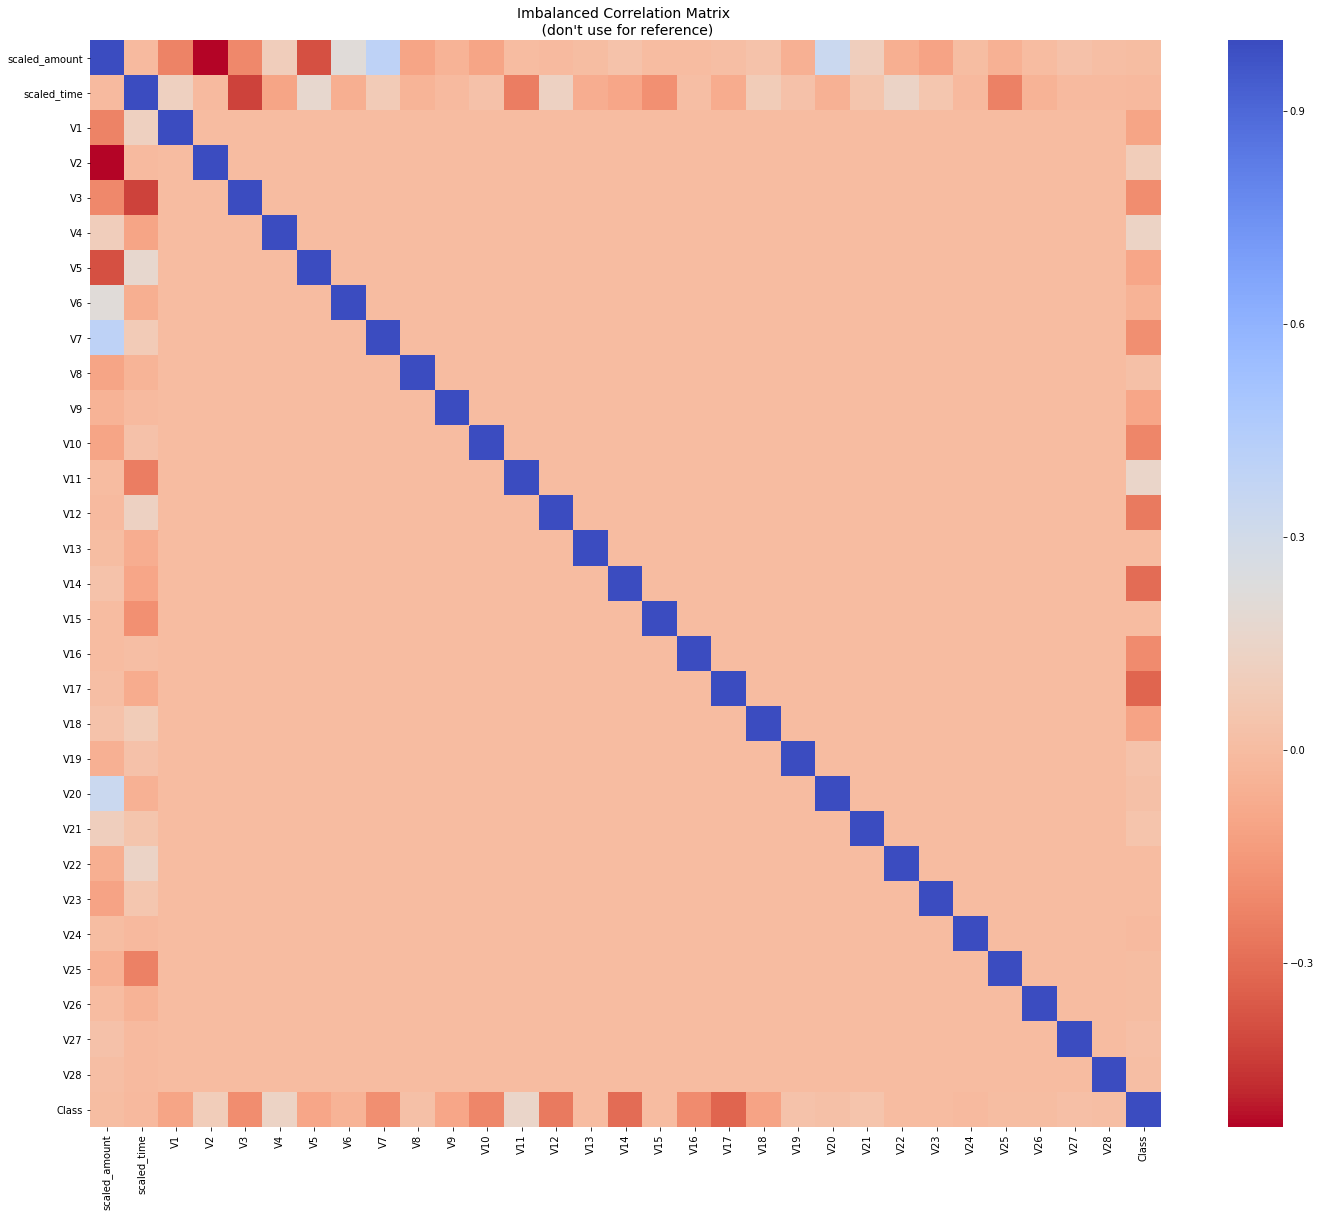

In [24]:
f, ax1 = plt.subplots(1, 1, figsize=(24,20))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

> Subsample data

Text(0.5,1,'SubSample Correlation Matrix \n (use for reference)')

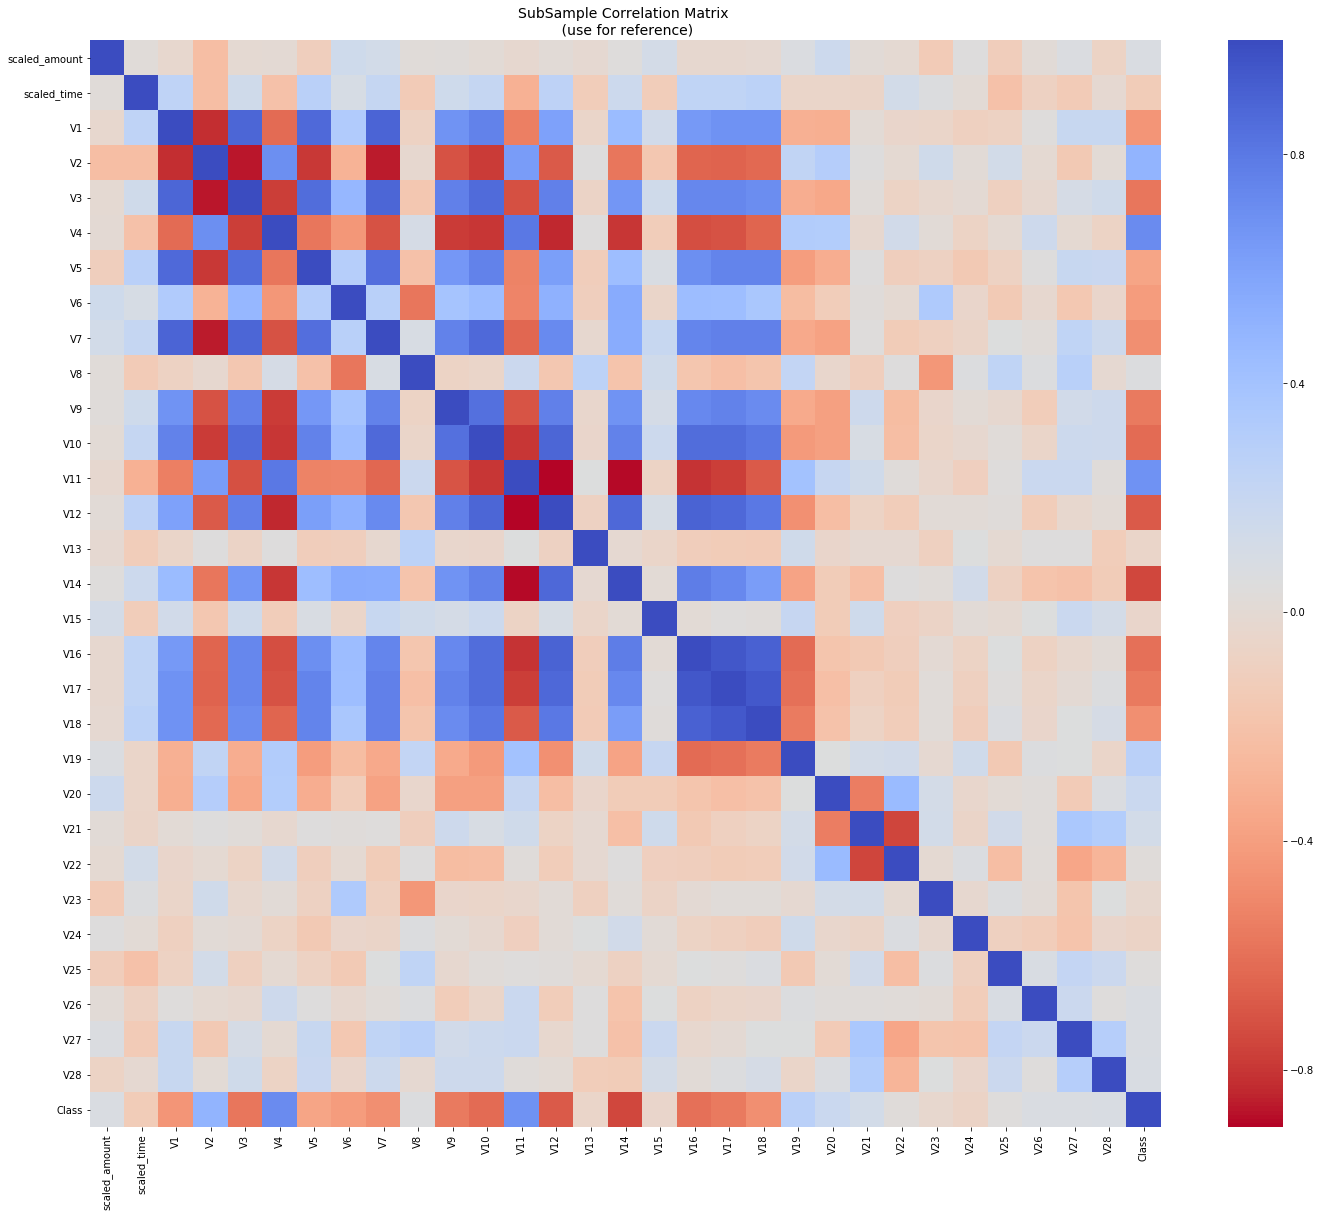

In [25]:
f, ax2 = plt.subplots(1, 1, figsize=(24,20))

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)

> 음의 상관관계가 강한 특성들 : `V17`, `V14`, `V12`, `V10`

Feature의 값이 작을수록 더욱 fraud 같다는 관계를 보여주는 특성들입니다.

Text(0.5,1,'V10 vs Class Negative Correlation')

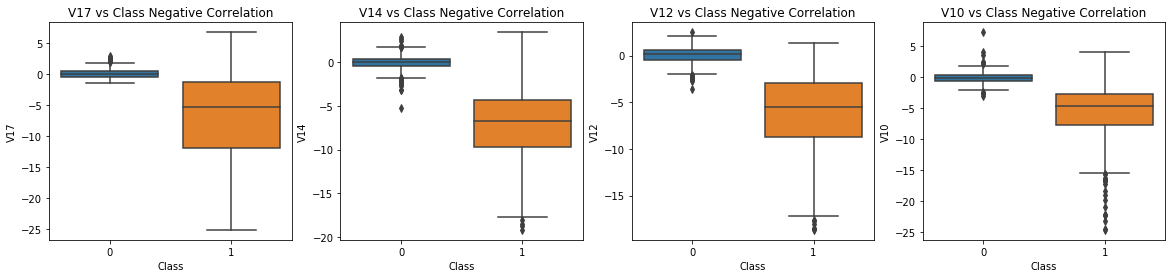

In [26]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=new_df, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

> 양의 상관관계가 강한 특성들 : `V11`, `V4`, `V2`, `V19`

Feature의 값이 클수록 더욱 fraud 같다는 관계를 보여주는 특성들입니다.

Text(0.5,1,'V19 vs Class Positive Correlation')

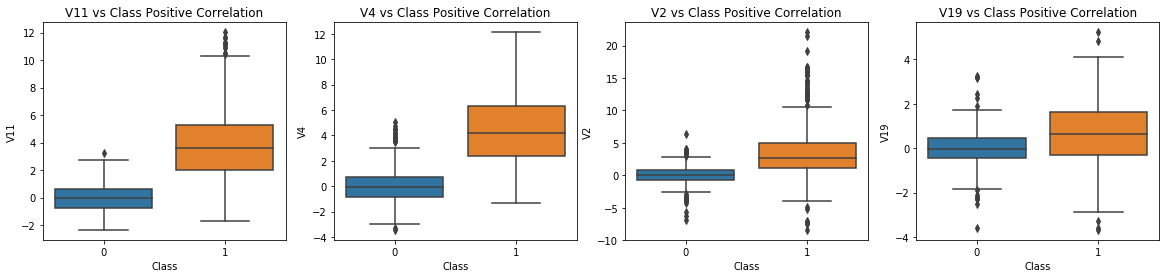

In [27]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=new_df,ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V2", data=new_df, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V19", data=new_df, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

## 3.2 Anomaly Detection:
<img src="https://discourse-cdn-sjc1.com/business6/uploads/analyticsvidhya/original/2X/d/d11281b44c2e440b36aaf29156b5032105d2d06b.png">

각 feature 별로, target variable(calss)에 강한 상관관계를 가지는 extreme outliers를 제거 할 것입니다.

V17은 fraud class에 outlier가 없습니다. V17은 제외하고 음의 상관관계가 강했던 데이터를 살펴보겠습니다.

/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'V10 Distribution \n (Fraud Transactions)')

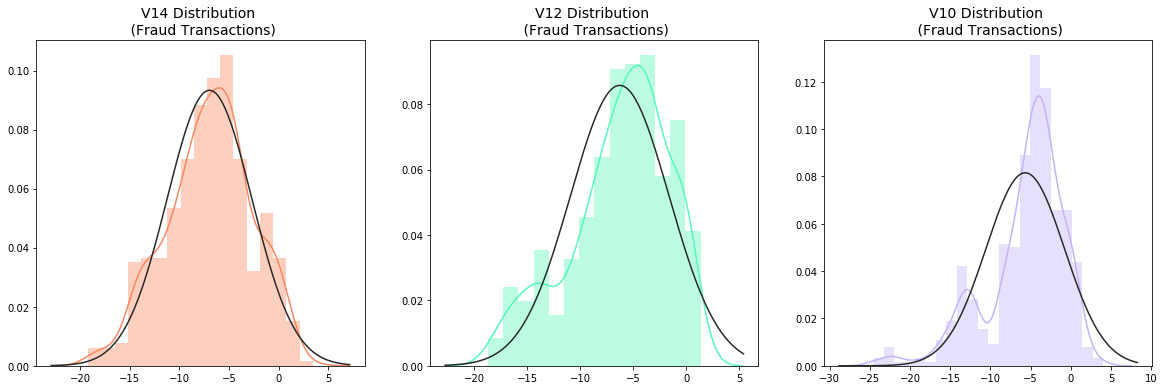

In [28]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

In [29]:
# V14
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('아웃라이어가 제거된 데이터의 크기: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.049997689859396, -18.8220867423816, -18.4937733551053, -19.2143254902614]
아웃라이어가 제거된 데이터의 크기: 980


In [30]:
# V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

v12_iqr = q75 - q25
print('iqr: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Cut Off: {}'.format(v12_cut_off))
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('아웃라이어가 제거된 데이터의 크기: {}'.format(len(new_df)))

Quartile 25: -8.67303320439115 | Quartile 75: -2.893030568676315
iqr: 5.780002635714835
Cut Off: 8.670003953572252
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.047596570821604, -18.4311310279993, -18.553697009645802, -18.683714633344298]
Feature V12 Outliers for Fraud Cases: 4
아웃라이어가 제거된 데이터의 크기: 976


In [31]:
# V10
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

v10_iqr = q75 - q25
print('iqr: {}'.format(v10_iqr))

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('Cut Off: {}'.format(v10_cut_off))
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('아웃라이어가 제거된 데이터의 크기: {}'.format(len(new_df)))

Quartile 25: -7.466658535821848 | Quartile 75: -2.5118611381562523
iqr: 4.954797397665596
Cut Off: 7.4321960964983935
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-19.836148851696, -15.1237521803455, -14.9246547735487, -14.9246547735487, -16.3035376590131, -16.2556117491401, -17.141513641289198, -16.7460441053944, -15.346098846877501, -15.2318333653018, -24.403184969972802, -16.6011969664137, -18.9132433348732, -15.2399619587112, -15.563791338730098, -15.124162814494698, -20.949191554361104, -15.2399619587112, -24.5882624372475, -23.2282548357516, -22.1870885620007, -22.1870885620007, -15.563791338730098, -18.2711681738888, -22.1870885620007, -22.1870885620007, -16.6496281595399]
Feature V10 Outliers for Fraud Cases: 27
아웃라이어가 제거된 데이터의 크기: 948


Extream outlier를 제거하고 난 후 다시 box plot을 그려보면 수정된 데이터를 기반으로 IQR이 재계산 되므로 아웃라이어가 물론 발생하긴 합니다. 

하지만 기존데이터에서 outlier를 제거하였기 때문에, 재계산된 outlier를 제거하지는 않겠습니다.

Text(0.5,1,'V10 Feature \n Reduction of outliers')

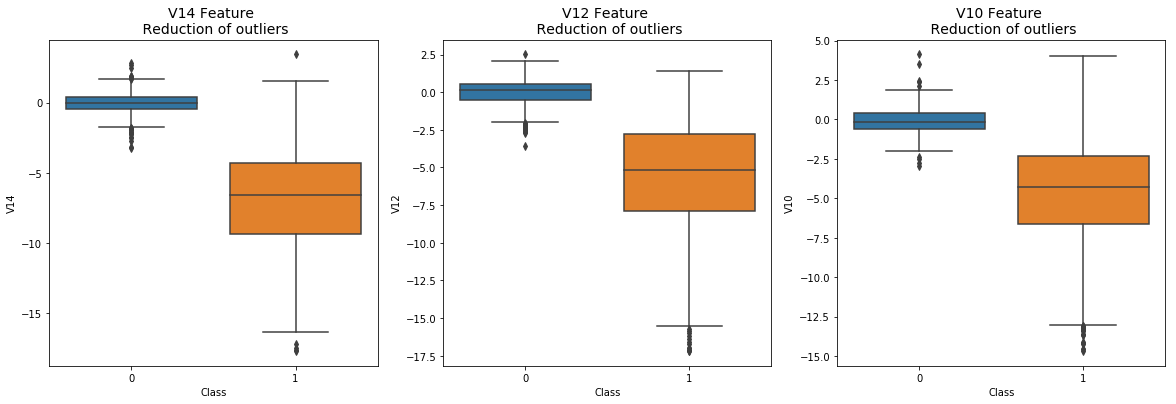

In [32]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

# Boxplots with outliers removed
# V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)

# 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)

# V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)

이런방법으로 양의 상관관계를 가지는 feature와 label이 0인 데이터에 대해서도 outlier 제거를 수행합니다.

# 4. Fraud detection
## 4.1 차원축소 및 클러스터링

- [t-SNE](https://www.youtube.com/watch?v=NEaUSP4YerM) (t-SNE는 정확하게 클러스터를 구분하는 알고리즘 중의 하나입니다)
- PCA
- SVD
- KMeans clustering

In [33]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [34]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()

print("T-SNE 소요 시간 {:.2} s".format(t1 - t0))

T-SNE 소요 시간 1.9e+01 s


In [35]:
# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()

print("PCA 소요 시간 {:.2} s".format(t1 - t0))

PCA 소요 시간 0.0055 s


In [36]:
# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()

print("Truncated SVD 소요 시간 {:.2} s".format(t1 - t0))

Truncated SVD 소요 시간 0.0041 s


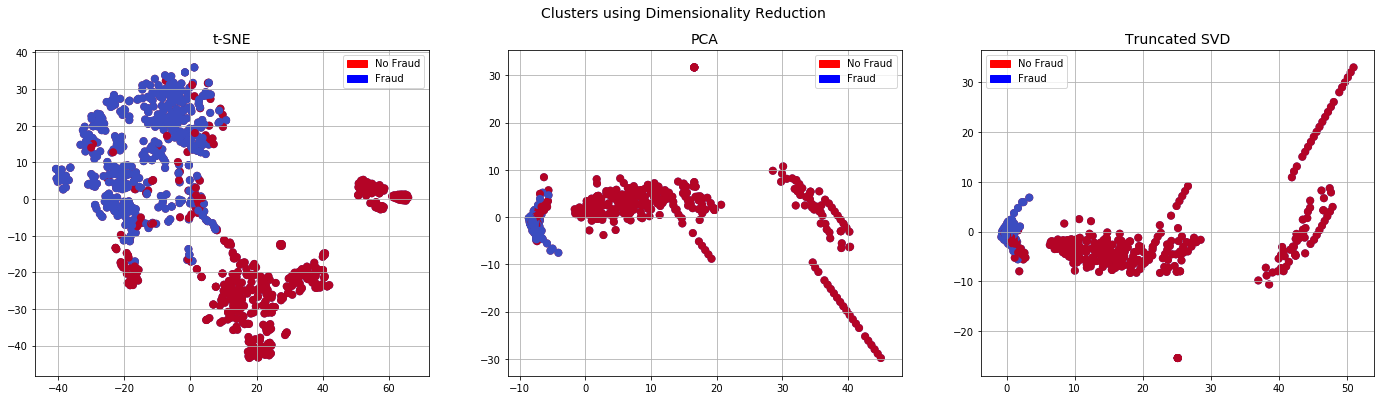

In [37]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='red', label='No Fraud')
red_patch = mpatches.Patch(color='blue', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

## 4.2 Classification (Random under sampling 데이터를 이용)


### 4.2.1 학습하기

In [38]:
new_df.shape

(948, 31)

In [39]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [40]:
from sklearn.model_selection import train_test_split

# Random under sampling이 1:1의 비율로 적용되었기 때문에 train_test_split을 사용합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [42]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

> Cross validation

In [43]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, 
          "- training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression - training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier - training score of 92.0 % accuracy score
Classifiers:  SVC - training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier - training score of 89.0 % accuracy score
Classifiers:  RandomForestClassifier - training score of 92.0 % accuracy score


> Search for hyperparameters

- Logistic regression

In [44]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression parameter
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

- K nearest neighbors

In [45]:
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_

- SVM

In [46]:
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

- Decisiontree classifier

In [47]:
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
               "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

- Randomforest classifier

In [48]:
# DecisionTree Classifier
rf_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
               "min_samples_leaf": list(range(5,7,1))}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf.fit(X_train, y_train)

# tree best estimator
rf_clf = grid_rf.best_estimator_

In [49]:
# 모델 비교
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

rf_score = cross_val_score(rf_clf, X_train, y_train, cv=5)
print('Randomforest Classifier Cross Validation Score', round(rf_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.28%
Knears Neighbors Cross Validation Score 92.49%
Support Vector Classifier Cross Validation Score 93.8%
DecisionTree Classifier Cross Validation Score 91.15%
Randomforest Classifier Cross Validation Score 92.22%


### 4.2.2 학습 도중 성능평가하기

> Learning curve

In [50]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

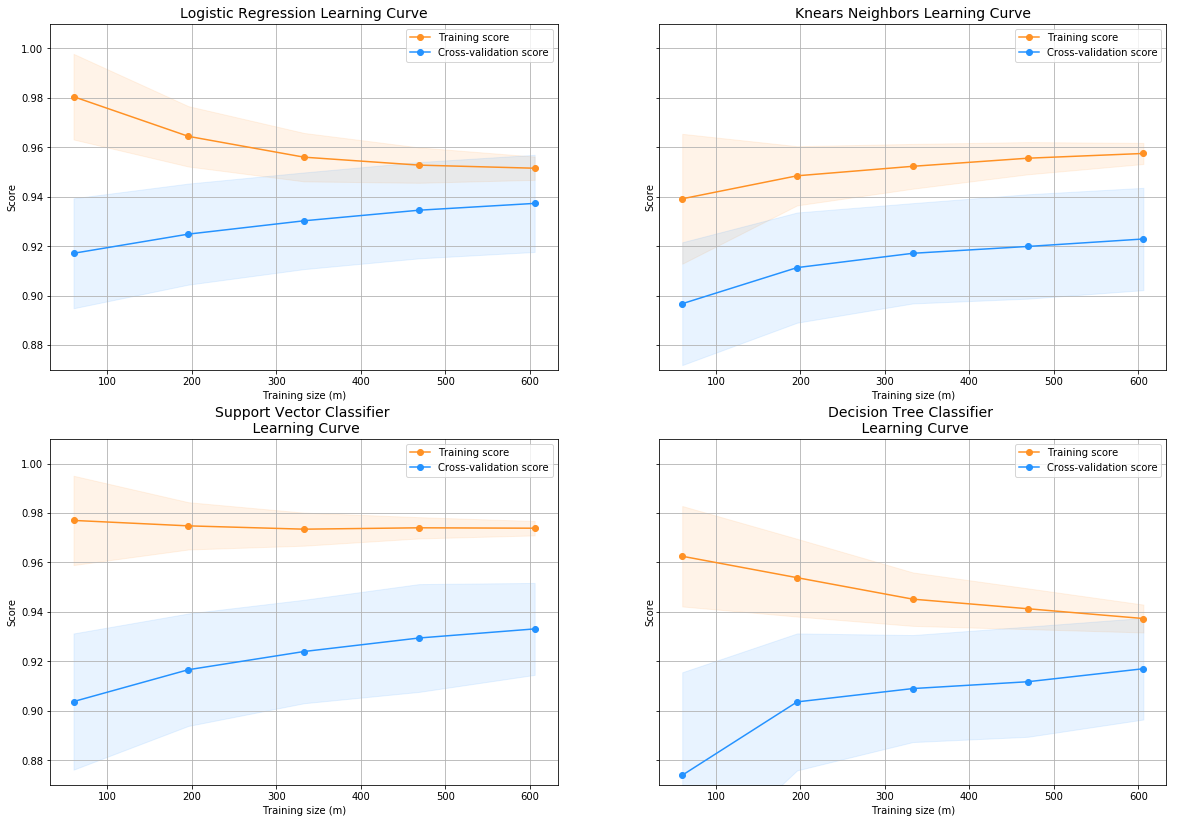

In [51]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

> Train set AUC

In [52]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9768201314616755
KNears Neighbors:  0.9240404968805704
Support Vector Classifier:  0.9736101827094473
Decision Tree Classifier:  0.9115767045454546


___
# Undersample & Oversample

In [63]:
from sklearn.metrics import average_precision_score, precision_recall_curve

## 1. Overfitting during Cross Validation

<font color=red>**It is simple, if you want to undersample or oversample your data you should not do it before cross validating. Why because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem.**</font>

### The Wrong Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401">

Test data는 절대 손대면 안되지만, 위의 경우는 test data가 이미 학습셋에 포함되어 있습니다. 즉 data leakage 문제가 발생합니다.

### The Right Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372">

**SMOTE**는 cross validation이 수행되는 도중에 oversampling을 합니다.

**References**: 
- https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation
- http://rikunert.com/SMOTE_explained
- https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s

## 2. SMOTE Technique (Over-Sampling):
Reference : https://www.hindawi.com/journals/mpe/2013/694809/

<img src="https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png", width=800>

Oversampling은 class imbalance problem을 해결하는 방법중 하나로, undersampling과 달리, majority class에 맞추어 oversampling을 수행합니다.

SMOTE(Synthetic Minority Over-sampling Technique):

- **Solving the Class Imbalance**: SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.
- **Location of the synthetic points**: SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.
- **Final Effect**: More information is retained since we didn't have to delete any rows unlike in random undersampling.
- **Accuracy || Time Tradeoff**: Although it is likely that <U>SMOTE will be more accurate than random under-sampling</U>, it will take more time to train since no rows are eliminated as previously stated.

In [54]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

Cross validation을 수행하기 직전, stratified data의 크기를 살펴봅니다.

In [55]:
print(len(original_X_train))
print(len(original_y_train))
print(len(original_X_test))
print(len(original_y_test))

227846
227846
56961
56961


In [56]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

In [57]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_sm = LogisticRegression()
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

> Cross validation using SMOTE

In [58]:
for train, test in sss.split(original_X_train, original_y_train):
    pipeline = imbalanced_make_pipeline(SMOTE(), rand_log_reg)
    model = pipeline.fit(original_X_train[train], original_y_train[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_X_train[test])
    
    accuracy_lst.append(pipeline.score(original_X_train[test], original_y_train[test]))
    precision_lst.append(precision_score(original_y_train[test], prediction))
    recall_lst.append(recall_score(original_y_train[test], prediction))
    f1_lst.append(f1_score(original_y_train[test], prediction))
    auc_lst.append(roc_auc_score(original_y_train[test], prediction))
    
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))

accuracy: 0.9620536705396671
precision: 0.06354928925426508
recall: 0.9136319376825707
f1: 0.11729894352224483


In [59]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_X_test)
print(classification_report(original_y_test, smote_prediction, target_names=labels))

             precision    recall  f1-score   support

   No Fraud       1.00      0.99      0.99     56863
      Fraud       0.11      0.86      0.20        98

avg / total       1.00      0.99      0.99     56961



In [60]:
y_score = best_est.decision_function(original_X_test)

average_precision_score : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html

In [61]:
average_precision = average_precision_score(original_y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.75


Text(0.5,1,'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.75')

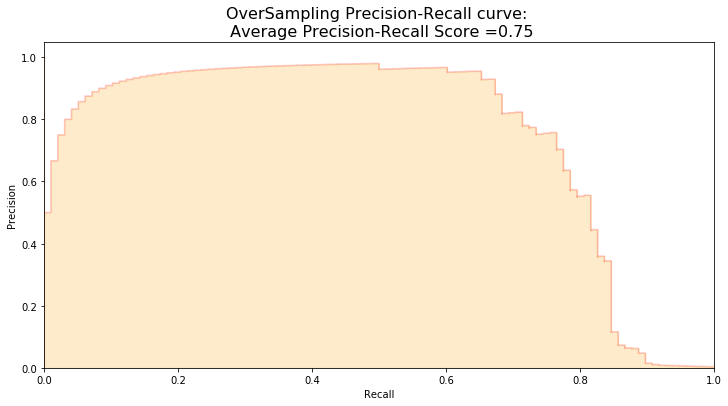

In [64]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_y_test, y_score)

plt.step(recall, precision, color='r', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

> 학습

In [65]:
sm = SMOTE(ratio='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_sample(original_X_train, original_y_train)

print(Xsm_train.shape)
print(ysm_train.shape)

(454904, 30)
(454904,)


In [66]:
# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :31.33479905128479 sec


## 3. NearMiss Technique (Under-sampling)

Reference : http://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf?attredirects=0

`undersample_pipeline = imbalanced_make_pipeline(NearMiss(), rand_log_reg)`을 사용하면 됩니다.

___

# 4.3 Test

## 7.1 Confusion Matrix:

In [67]:
# Under-sampling 되었던 데이터
print(X_test.shape)
print(y_test.shape)

(190, 30)
(190,)


In [68]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Random sunder ampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

[Text(0,0.5,''), Text(0,1.5,'')]

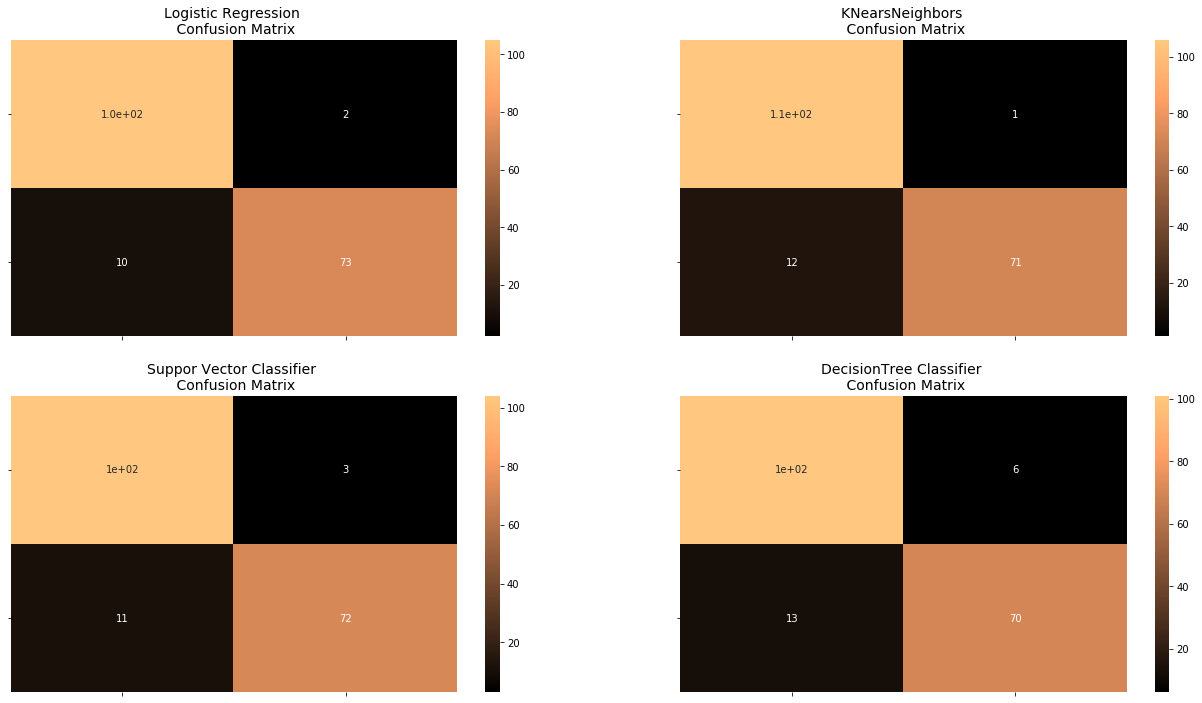

In [69]:
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))

sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=25, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=25, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=25, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=25, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=25, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=25, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=25, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=25, rotation=360)

In [70]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
             precision    recall  f1-score   support

          0       0.91      0.98      0.95       107
          1       0.97      0.88      0.92        83

avg / total       0.94      0.94      0.94       190

KNears Neighbors:
             precision    recall  f1-score   support

          0       0.90      0.99      0.94       107
          1       0.99      0.86      0.92        83

avg / total       0.94      0.93      0.93       190

Support Vector Classifier:
             precision    recall  f1-score   support

          0       0.90      0.97      0.94       107
          1       0.96      0.87      0.91        83

avg / total       0.93      0.93      0.93       190

Support Vector Classifier:
             precision    recall  f1-score   support

          0       0.89      0.94      0.91       107
          1       0.92      0.84      0.88        83

avg / total       0.90      0.90      0.90       190



성능 평가를 하면서, 범하기 쉬운 실수는 다음과 같습니다.

In [71]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

In [72]:
# Logistic Regression with Random Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

In [73]:
# Logistic Regression with SMOTE Technique
y_pred_sm = best_est.predict(original_X_test)
oversample_score = accuracy_score(original_y_test, y_pred_sm)

In [74]:
d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

In [75]:
# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Technique,Score
0,Random UnderSampling,0.936842
1,Oversampling (SMOTE),0.988220


In [83]:
# SMOTE
print(classification_report(original_y_test, y_pred_sm))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     56863
          1       0.11      0.86      0.20        98

avg / total       1.00      0.99      0.99     56961



In [84]:
print(classification_report(original_y_test, log_reg.predict(original_X_test)))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     56863
          1       0.12      0.87      0.20        98

avg / total       1.00      0.99      0.99     56961



# 5. Neural Networks with Random Under-Sampling Data vs OverSampling

In [85]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

Using TensorFlow backend.


In [86]:
undersample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [87]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [88]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 606 samples, validate on 152 samples
Epoch 1/20
 - 0s - loss: 0.6521 - acc: 0.5693 - val_loss: 0.4532 - val_acc: 0.6776
Epoch 2/20
 - 0s - loss: 0.3948 - acc: 0.8168 - val_loss: 0.3172 - val_acc: 0.9013
Epoch 3/20
 - 0s - loss: 0.2940 - acc: 0.9191 - val_loss: 0.2540 - val_acc: 0.9408
Epoch 4/20
 - 0s - loss: 0.2414 - acc: 0.9257 - val_loss: 0.2195 - val_acc: 0.9342
Epoch 5/20
 - 0s - loss: 0.2061 - acc: 0.9274 - val_loss: 0.1964 - val_acc: 0.9342
Epoch 6/20
 - 0s - loss: 0.1819 - acc: 0.9323 - val_loss: 0.1807 - val_acc: 0.9276
Epoch 7/20
 - 0s - loss: 0.1633 - acc: 0.9389 - val_loss: 0.1734 - val_acc: 0.9276
Epoch 8/20
 - 0s - loss: 0.1504 - acc: 0.9472 - val_loss: 0.1672 - val_acc: 0.9276
Epoch 9/20
 - 0s - loss: 0.1393 - acc: 0.9488 - val_loss: 0.1642 - val_acc: 0.9211
Epoch 10/20
 - 0s - loss: 0.1317 - acc: 0.9521 - val_loss: 0.1623 - val_acc: 0.9276
Epoch 11/20
 - 0s - loss: 0.1248 - acc: 0.9521 - val_loss: 0.1610 - val_acc: 0.9211
Epoch 12/20
 - 0s - loss: 0.1189 - acc:

In [89]:
undersample_predictions = undersample_model.predict(original_X_test, batch_size=200, verbose=0)

In [90]:
undersample_fraud_predictions = undersample_model.predict_classes(original_X_test, batch_size=200, verbose=0)

In [91]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[54422  2441]
 [    7    91]]


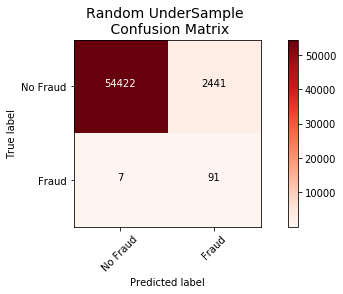

In [92]:
undersample_cm = confusion_matrix(original_y_test, undersample_fraud_predictions)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(8,4))

fig.add_subplot(111)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

### Keras with OverSampling (SMOTE):

In [93]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [94]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [95]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 2s - loss: 0.0689 - acc: 0.9764 - val_loss: 0.0234 - val_acc: 0.9936
Epoch 2/20
 - 2s - loss: 0.0156 - acc: 0.9964 - val_loss: 0.0138 - val_acc: 0.9992
Epoch 3/20
 - 2s - loss: 0.0086 - acc: 0.9984 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 4/20
 - 1s - loss: 0.0060 - acc: 0.9989 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 5/20
 - 1s - loss: 0.0046 - acc: 0.9991 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 6/20
 - 1s - loss: 0.0037 - acc: 0.9993 - val_loss: 9.2678e-04 - val_acc: 1.0000
Epoch 7/20
 - 2s - loss: 0.0031 - acc: 0.9994 - val_loss: 0.0026 - val_acc: 0.9998
Epoch 8/20
 - 1s - loss: 0.0030 - acc: 0.9994 - val_loss: 8.5292e-04 - val_acc: 1.0000
Epoch 9/20
 - 2s - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0236 - val_acc: 0.9961
Epoch 10/20
 - 2s - loss: 0.0027 - acc: 0.9995 - val_loss: 6.4186e-04 - val_acc: 1.0000
Epoch 11/20
 - 1s - loss: 0.0020 - acc: 0.9996 - val_loss: 9.9438e-04 - val_acc: 1.0000
Epoch 12/20
 - 1s 

In [96]:
oversample_predictions = oversample_model.predict(original_X_test, batch_size=200, verbose=0)

In [97]:
oversample_fraud_predictions = oversample_model.predict_classes(original_X_test, batch_size=200, verbose=0)

Confusion matrix, without normalization
[[56847    16]
 [   26    72]]


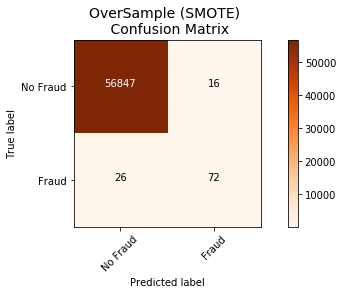

In [98]:
oversample_smote = confusion_matrix(original_y_test, oversample_fraud_predictions)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(8,4))

fig.add_subplot(111)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)